# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

import shap
from xgboost import plot_importance

2022-01-17 11:33:51.127011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-17 11:33:51.127043: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data
df.drop(df[df.SHSeizComaPast12mos == 2].index, inplace=True)
# df.drop(df[df.Pt_SevHypoEver == 2].index, inplace=True)

### for SH events prediction pre processing


In [5]:
# check patients count with SHSeizComaPast12mos and not Pt_SevHypoEver
# df.loc[(df['SHSeizComaPast12mos']==0) & (df['Pt_SevHypoEver']==1)]

In [6]:
y_label = 'SHSeizComaPast12mos' 
# possible labels Pt_SevHypoEver, SHSeizComaPast12mos, DKAPast12mos, Depression, DiabNeuro, DKADiag

In [7]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['SHSeizComaPast12mos'])):
        if((row['NumSHSeizComaPast12mos'] >= 1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [8]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(get_possible_vals_with_nan(df, y_label))


[1.0, 0.0]


In [9]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'ReqInsulinCrit',

In [10]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872,10.0


# Divide Dataset

In [11]:
df=df.drop('PtID', axis = 1)

In [12]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [13]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,Pt_InsUnk,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
7,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
40,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872,10.0


In [14]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [15]:
Y.unique()

array([1., 0.])

# Feature Selection

In [16]:
shape = np.shape(X) 
feature = 25 #shape[1] 
n_classes = 2


In [17]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [18]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [ 154 4837]
Test -  [0. 1.] [  51 1613]


# Imputations

<AxesSubplot:>

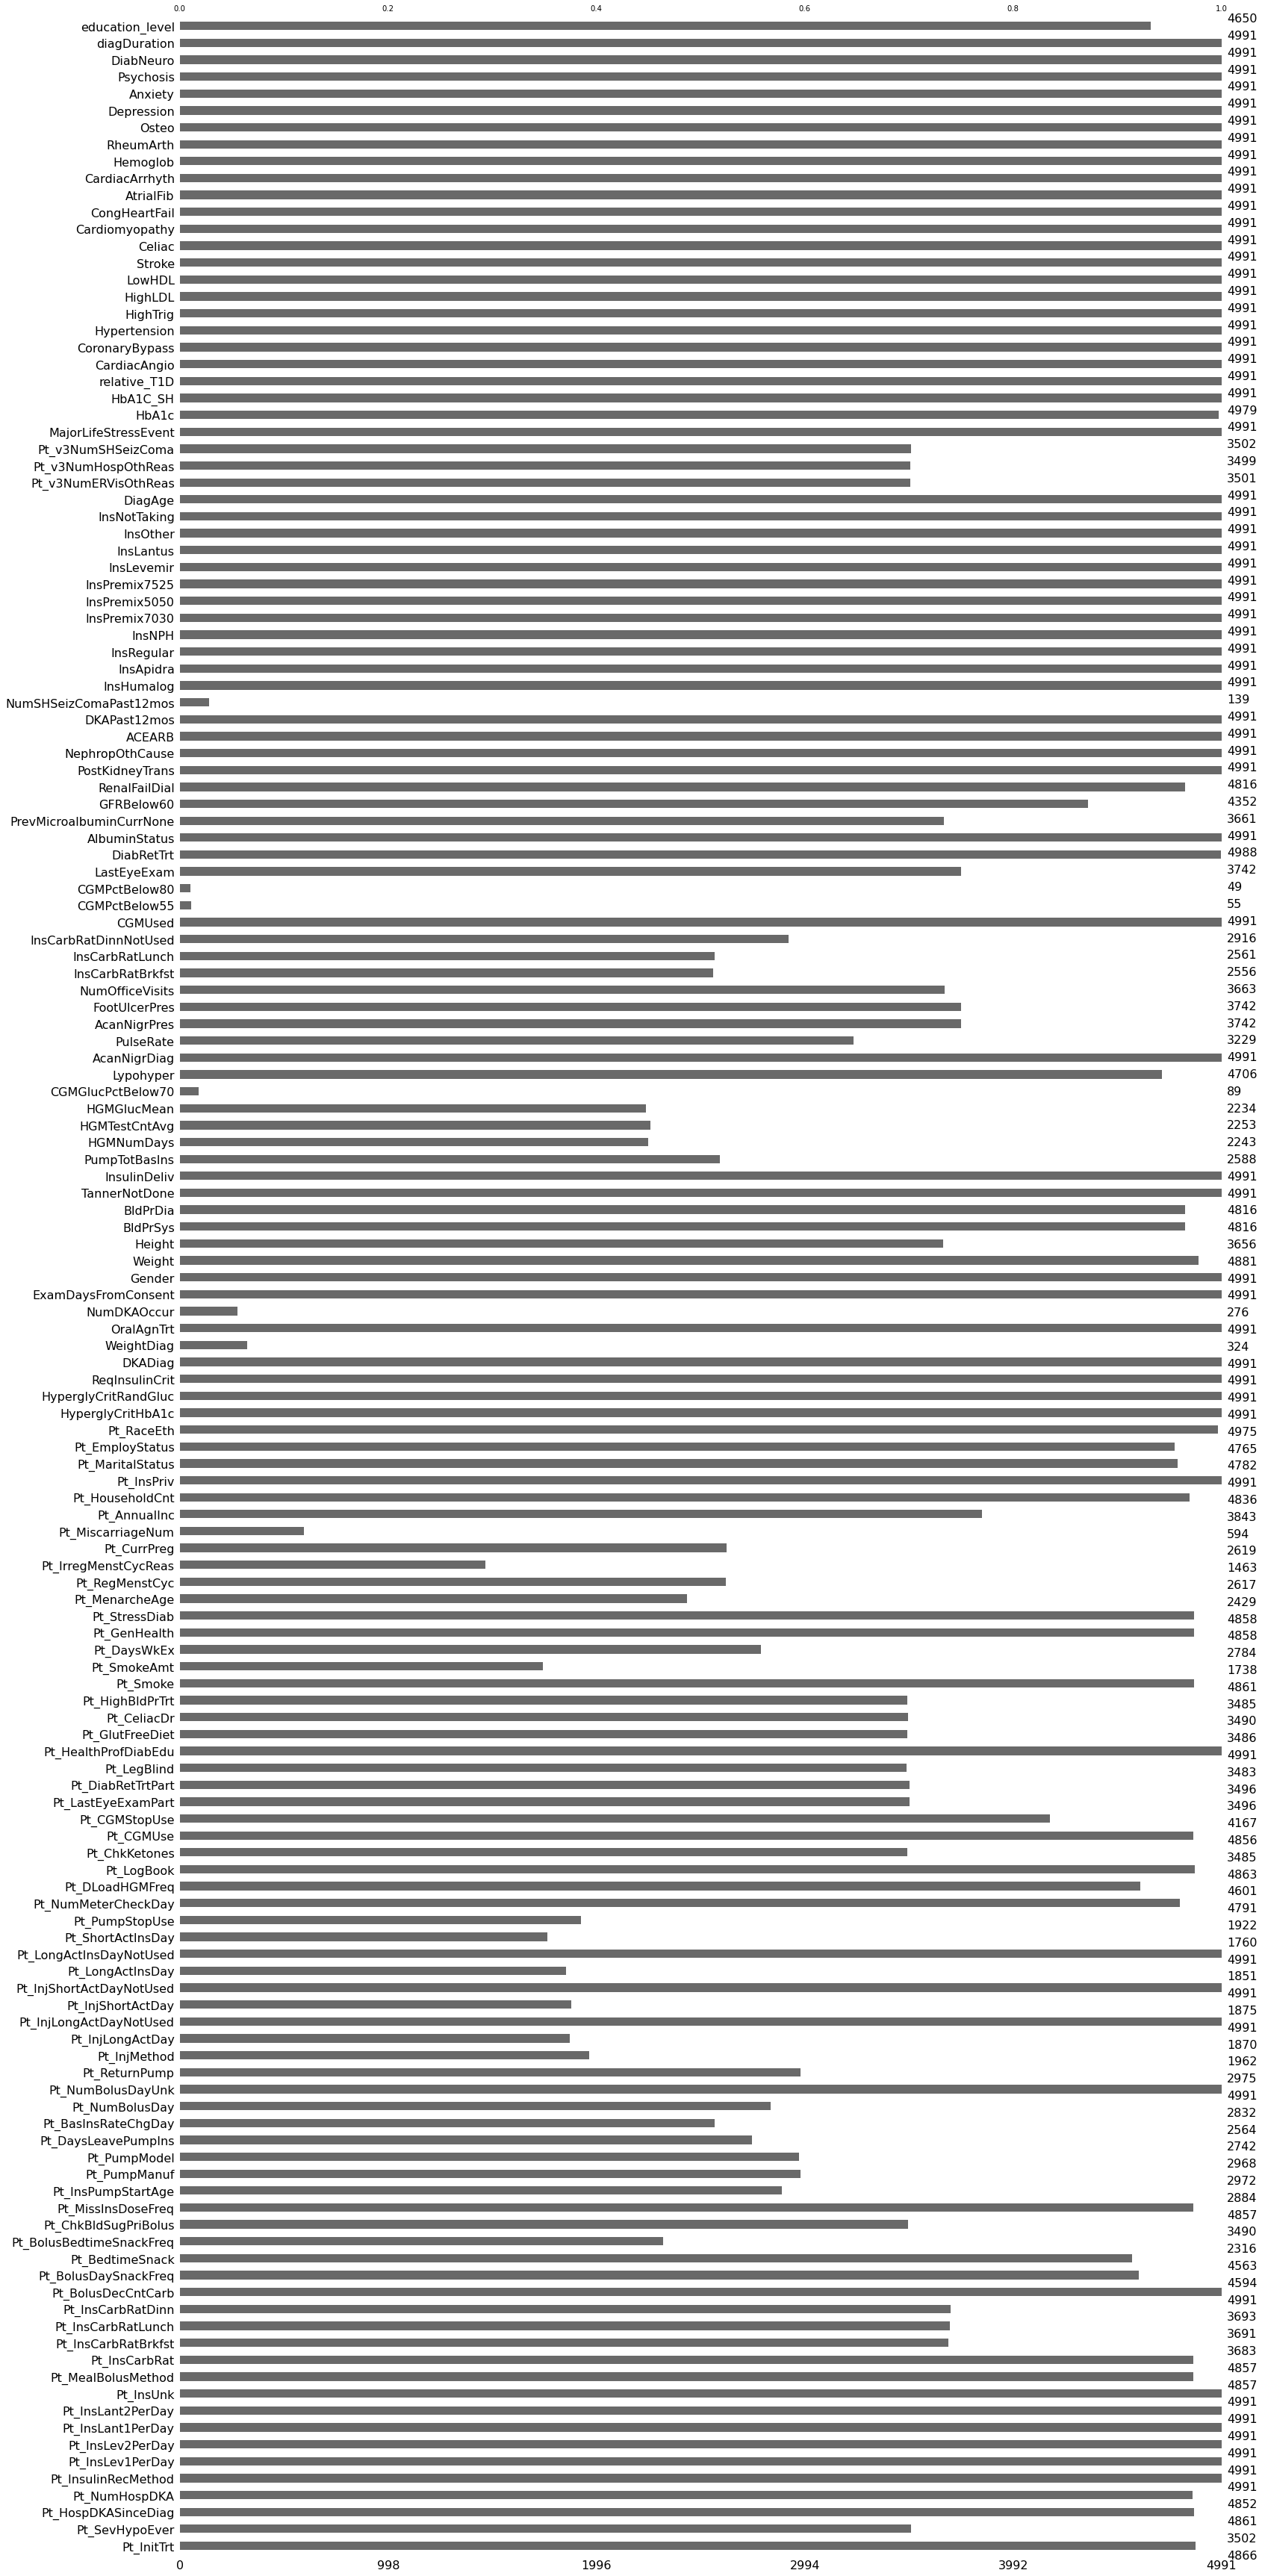

In [19]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [20]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [21]:
# use only for XGB classifier with missing values
# X_train_copy = X_train.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)
# X_test_copy = X_test.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumSHSeizComaPast12mos'], axis=1)
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
# if('Pt_SevHypoEver' in X_train.columns):
#     X_train_copy = X_train_copy.drop(['Pt_SevHypoEver'], axis=1)
#     X_test_copy = X_test_copy.drop(['Pt_SevHypoEver'], axis=1)

# feature_list = ['Pt_SevHypoEver', 'Pt_InsLant2PerDay', 'Pt_InsCarbRat',
#        'Pt_DaysLeavePumpIns', 'Pt_NumBolusDay', 'Pt_InjShortActDay',
#        'Pt_PumpStopUse', 'Pt_DLoadHGMFreq', 'Pt_CGMUse', 'Pt_LegBlind',
#        'Pt_IrregMenstCycReas', 'Pt_MaritalStatus', 'Pt_EmployStatus',
#        'ReqInsulinCrit', 'ExamDaysFromConsent', 'BldPrSys', 'HGMNumDays',
#        'AcanNigrDiag', 'AcanNigrPres', 'FootUlcerPres', 'NumOfficeVisits',
#        'CGMUsed', 'CGMPctBelow80', 'LastEyeExam', 'AlbuminStatus',
#        'GFRBelow60', 'HighLDL',
#        'CardiacArrhyth']


# X_train_copy = X_train_copy[feature_list]
# X_test_copy = X_test_copy[feature_list]
    

In [22]:
kf = KFold(n_splits= 10, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()




def cross_val_with_missing_val(model,n_splits=5):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
#         X_test1 = train.iloc[test_index][X_train_copy.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model


    

    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1






#     dfs = []
#     y_true, y_pred = list(), list()
#     for train_index, test_index in cv.split(train, Y_train):

#         X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
#         X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index].loc[:,y_label]

# #         Train the model
#         model.fit(X_train1, y_train1) #Training the model

    return model



Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.9659318637274549, doublecheck: 0.9659318637274549
Accuracy for the fold no. 8 on the test set: 0.9659318637274549, doublecheck: 0.9659318637274549
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869

 
 ===========   Train Dataset    =============
train ROC score 

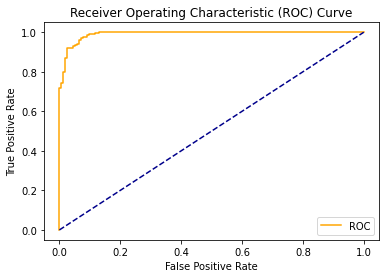

accuracy score:  96.91444600280505
              precision    recall  f1-score   support

         0.0       0.50      0.93      0.65       154
         1.0       1.00      0.97      0.98      4837

    accuracy                           0.97      4991
   macro avg       0.75      0.95      0.82      4991
weighted avg       0.98      0.97      0.97      4991



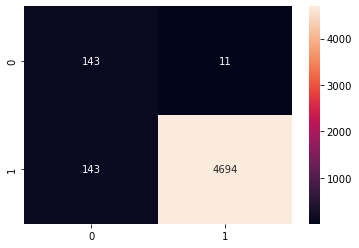

Accuracy of XGB on training set: 0.99


 ===========   Test Dataset    =============
Threshold value is: 2.5786772


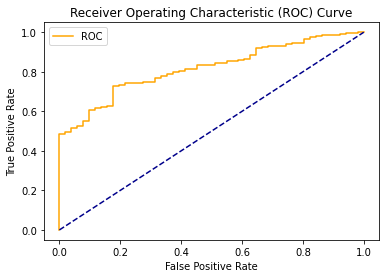

accuracy score:  73.07692307692307
              precision    recall  f1-score   support

         0.0       0.09      0.82      0.16        51
         1.0       0.99      0.73      0.84      1613

    accuracy                           0.73      1664
   macro avg       0.54      0.78      0.50      1664
weighted avg       0.96      0.73      0.82      1664



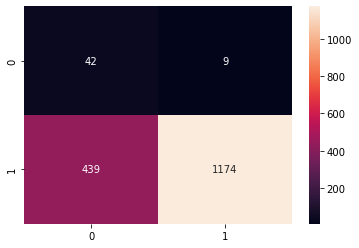

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8162


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.82352941 0.72783633]
average accuracy:  0.7756828707924583
f1 0.8397711015736767


In [23]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
#         n_jobs = 0,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )

# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model, 10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

<AxesSubplot:>

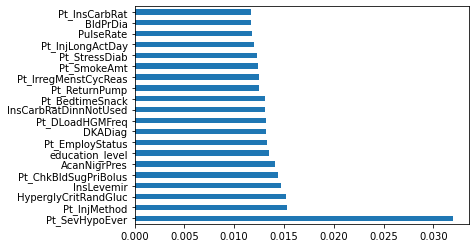

In [24]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:199])
feat_importances.nlargest(20).plot(kind='barh')


In [25]:
X_test_copy.head(1)
# RED - positive (high) impact
explainer = shap.TreeExplainer(model, X_test_copy.head(1), feature_perturbation = 'interventional', model_output="raw" )

# shap_values = explainer.shap_values(X_test_copy.iloc[0].to_frame())

# shap.summary_plot(shap_values, X_test_copy.iloc[0].to_frame())

In [26]:
shap_values = explainer.shap_values(X_test_copy.head(1))

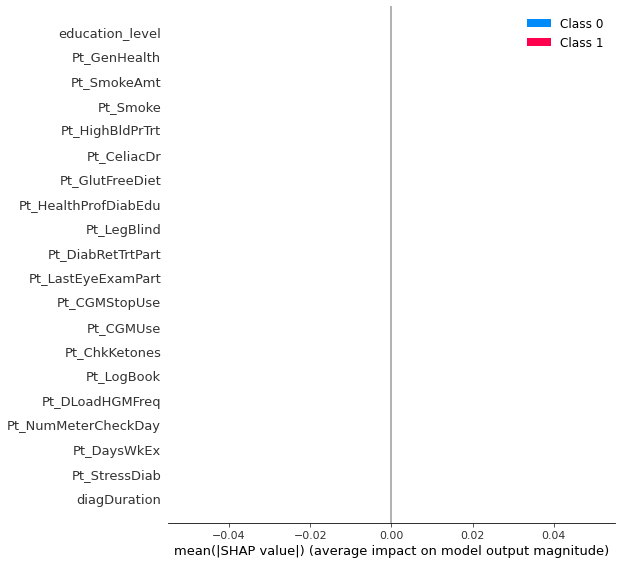

In [27]:
shap.summary_plot(shap_values, X_test_copy.head(1))

Attempting to set identical left == right == 2.7377366826403886 results in singular transformations; automatically expanding.


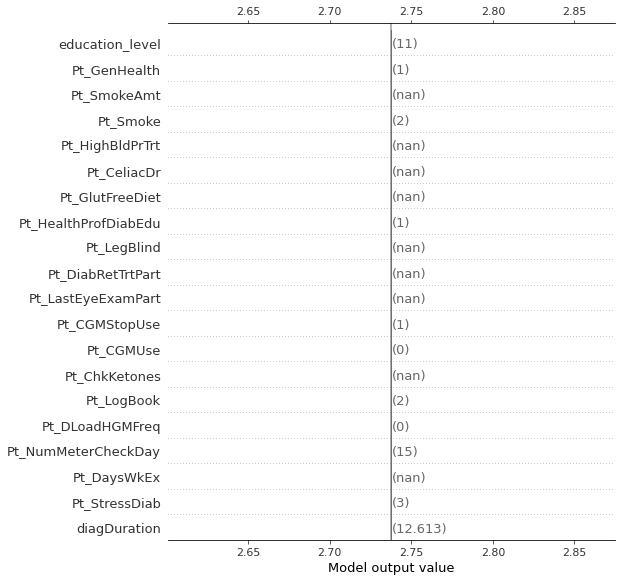

In [28]:
# plt.switch_backend('agg') 
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_train_copy, ignore_warnings=True)

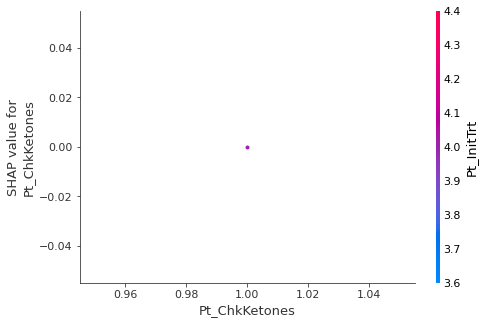

In [29]:
shap.dependence_plot("Pt_ChkKetones", shap_values[1], X_test_copy.head(1))

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 3 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.9659318637274549, doublecheck: 0.9659318637274549
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869

 
 ===========   Train Dataset    =============
train ROC 

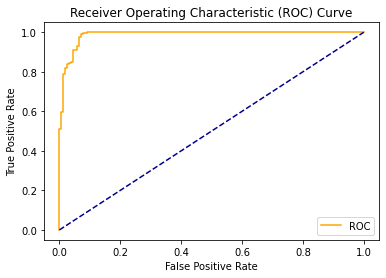

accuracy score:  99.05830494890805
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86       154
         1.0       1.00      0.99      1.00      4837

    accuracy                           0.99      4991
   macro avg       0.90      0.96      0.93      4991
weighted avg       0.99      0.99      0.99      4991



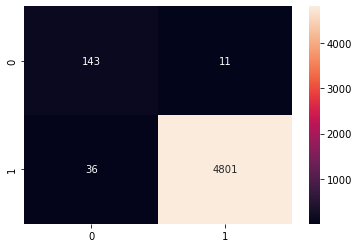

Accuracy of XGB on training set: 1.00


 ===========   Test Dataset    =============
Threshold value is: 0.9931504007802879


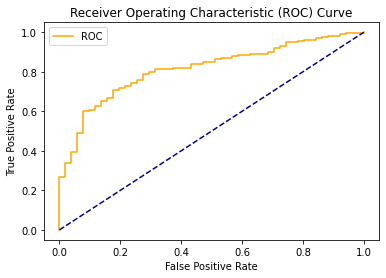

accuracy score:  71.33413461538461
              precision    recall  f1-score   support

         0.0       0.08      0.82      0.15        51
         1.0       0.99      0.71      0.83      1613

    accuracy                           0.71      1664
   macro avg       0.54      0.77      0.49      1664
weighted avg       0.96      0.71      0.81      1664



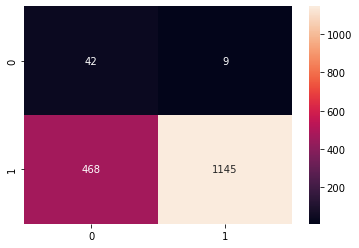

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.8138


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.82352941 0.70985741]
average accuracy:  0.7666934101600962
f1 0.8276111311890133


In [30]:

import lightgbm as ltb

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.1, 
                         max_depth =5, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model,10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

In [31]:
   
X_train.update(X_train[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsUnk','HyperglyCritHbA1c']].fillna(0))

X_test.update(X_test[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsUnk','HyperglyCritHbA1c']].fillna(0))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
# imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
imputeX = IterativeImputer(missing_values=np.nan,sample_posterior= True,max_iter=15,
                           initial_strategy='most_frequent', random_state=0)

X_train = imputeX.fit_transform(X_train)


In [33]:
# ###############
# import datawig

# imputer = datawig.SimpleImputer()
# imputer.fit(train_df = X_train, num_epochs=50)
# X_test = imputer.predict(X_test)
# X_train = imputer.predict(X_train)

In [34]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [35]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))


## Feature Selection

In [36]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [37]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [38]:
# Feature selection
selected, fs, idx = select_features(select, feature)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:39:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:40:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)



Index(['Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_InsLev2PerDay',
       'Pt_InsLant2PerDay', 'Pt_BedtimeSnack', 'Pt_BolusBedtimeSnackFreq',
       'Pt_PumpStopUse', 'Pt_CGMUse', 'Pt_LastEyeExamPart', 'Pt_LegBlind',
       'Pt_CurrPreg', 'Pt_AnnualInc', 'Pt_MaritalStatus', 'Pt_EmployStatus',
       'ExamDaysFromConsent', 'Height', 'CGMGlucPctBelow70', 'AcanNigrDiag',
       'NumOfficeVisits', 'InsCarbRatDinnNotUsed', 'AlbuminStatus',
       'NumSHSeizComaPast12mos', 'Pt_v3NumHospOthReas', 'Pt_v3NumSHSeizComa',
       'education_level'],
      dtype='object')
(6655, 25)


In [40]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [41]:
# X_train.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)
# X_test.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)

# if('Pt_SevHypoEver' in X_train.columns):
#     X_train = X_train.drop(['Pt_SevHypoEver'], axis=1)
#     X_test = X_test.drop(['Pt_SevHypoEver'], axis=1)
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train = X_train.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test = X_test.drop([ 'NumSHSeizComaPast12mos'], axis=1)
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train = X_train.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test = X_test.drop(['Pt_v3NumSHSeizComa'], axis=1)


### Common functions

In [42]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model, n_splits=5):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



In [43]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr)
    plt.show()
    return optimal_threshold

In [44]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))
    
    print('f1', metrics.f1_score(pred, Y_test))    

Accuracy for the fold no. 1 on the test set: 0.964, doublecheck: 0.964
Accuracy for the fold no. 2 on the test set: 0.9639278557114228, doublecheck: 0.9639278557114228
Accuracy for the fold no. 3 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9659318637274549, doublecheck: 0.9659318637274549
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.9714833440283098
Threshold value is: 0.8923710588

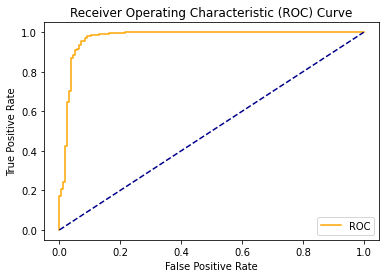

Test ROC
0.785711680828562
Threshold value is: 0.9907815448533192


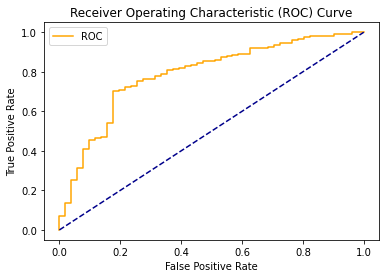


 
 =====================   Train Dataset    ======================
97.79603285914646
              precision    recall  f1-score   support

         0.0       0.59      0.91      0.72       154
         1.0       1.00      0.98      0.99      4837

    accuracy                           0.98      4991
   macro avg       0.80      0.94      0.85      4991
weighted avg       0.98      0.98      0.98      4991



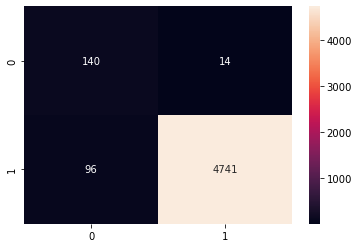

Accuracy of on training set: 0.99


 =====================   Test Dataset    =======================
70.49278846153845
              precision    recall  f1-score   support

         0.0       0.08      0.82      0.15        51
         1.0       0.99      0.70      0.82      1613

    accuracy                           0.70      1664
   macro avg       0.54      0.76      0.48      1664
weighted avg       0.96      0.70      0.80      1664



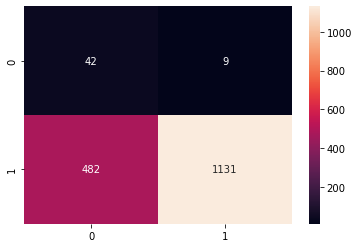

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7857


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.82352941 0.70117793]
average accuracy:  0.7623536705444731
f1 0.8216491100617508


In [45]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model=ltb.LGBMClassifier(use_missing = False,
                         learning_rate = 0.1, 
                         max_depth =5, random_state=0 )
# adaboost.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)


<AxesSubplot:>

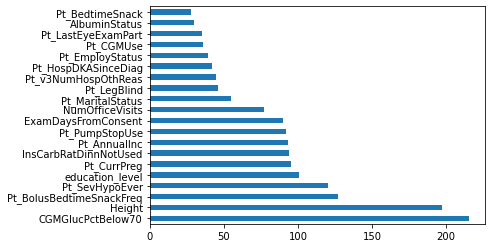

In [46]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 8 on the test set: 0.9639278557114228, doublecheck: 0.9639278557114228
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9639278557114228, doublecheck: 0.9639278557114228
Train ROC
0.896213978289645
Threshold value is: 0.5184254303683

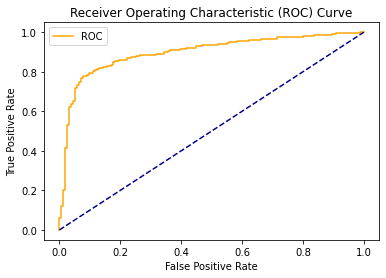

Test ROC
0.7729112723824806
Threshold value is: 0.5183866962137679


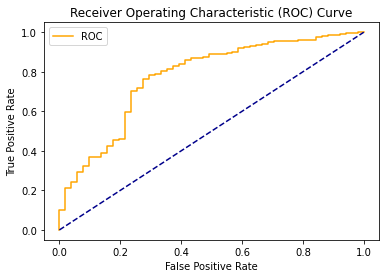


 
 =====================   Train Dataset    ======================
78.1406531757163
              precision    recall  f1-score   support

         0.0       0.12      0.92      0.21       154
         1.0       1.00      0.78      0.87      4837

    accuracy                           0.78      4991
   macro avg       0.56      0.85      0.54      4991
weighted avg       0.97      0.78      0.85      4991



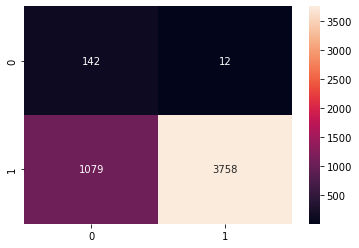

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
78.125
              precision    recall  f1-score   support

         0.0       0.09      0.71      0.17        51
         1.0       0.99      0.78      0.87      1613

    accuracy                           0.78      1664
   macro avg       0.54      0.74      0.52      1664
weighted avg       0.96      0.78      0.85      1664



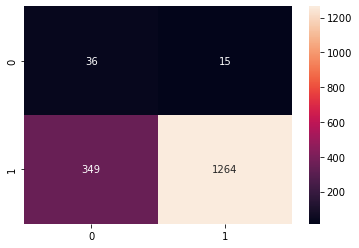

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7729


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.70588235 0.78363298]
average accuracy:  0.7447576674811276
f1 0.8741355463347165


In [47]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0, learning_rate=0.05, n_estimators=1000, algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

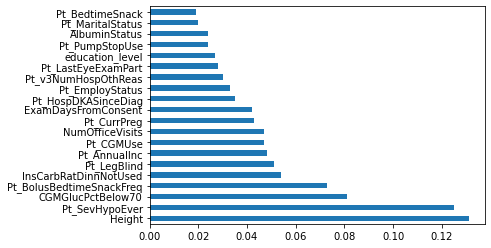

In [48]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.966, doublecheck: 0.966
Accuracy for the fold no. 2 on the test set: 0.9639278557114228, doublecheck: 0.9639278557114228
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 8 on the test set: 0.9659318637274549, doublecheck: 0.9659318637274549
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9659318637274549, doublecheck: 0.9659318637274549
Train ROC
0.9686775907573922
Threshold value is: 1.8582646


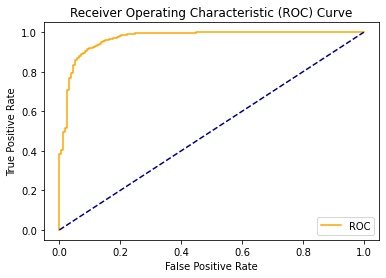

Test ROC
0.7842894132234419
Threshold value is: 2.2148178


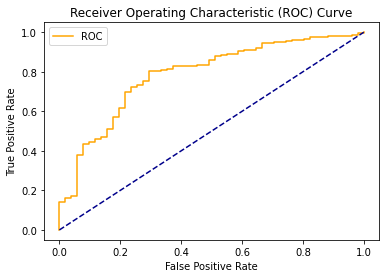


 
 =====================   Train Dataset    ======================
91.68503305950712
              precision    recall  f1-score   support

         0.0       0.26      0.91      0.40       154
         1.0       1.00      0.92      0.96      4837

    accuracy                           0.92      4991
   macro avg       0.63      0.91      0.68      4991
weighted avg       0.97      0.92      0.94      4991



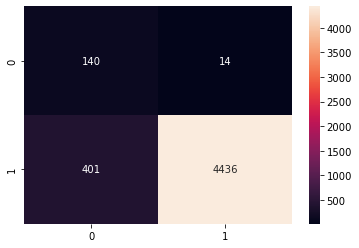

Accuracy of on training set: 0.98


 =====================   Test Dataset    =======================
79.86778846153845
              precision    recall  f1-score   support

         0.0       0.10      0.71      0.18        51
         1.0       0.99      0.80      0.89      1613

    accuracy                           0.80      1664
   macro avg       0.54      0.75      0.53      1664
weighted avg       0.96      0.80      0.86      1664



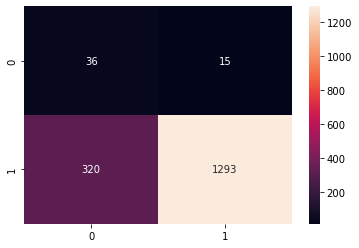

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7843


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.70588235 0.8016119 ]
average accuracy:  0.7537471281134898
f1 0.8853132488873674


In [49]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
#         max_delta_step = 10,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute,10)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

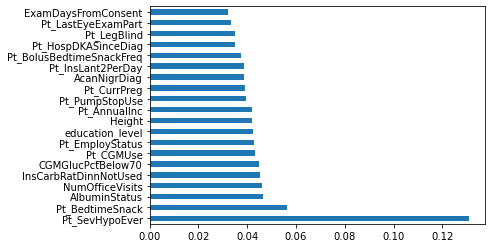

In [50]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.956, doublecheck: 0.956
Accuracy for the fold no. 2 on the test set: 0.9639278557114228, doublecheck: 0.9639278557114228
Accuracy for the fold no. 3 on the test set: 0.9579158316633266, doublecheck: 0.9579158316633266
Accuracy for the fold no. 4 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 5 on the test set: 0.9559118236472945, doublecheck: 0.9559118236472945
Accuracy for the fold no. 6 on the test set: 0.9519038076152304, doublecheck: 0.9519038076152304
Accuracy for the fold no. 7 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 8 on the test set: 0.9559118236472945, doublecheck: 0.9559118236472945
Accuracy for the fold no. 9 on the test set: 0.9579158316633266, doublecheck: 0.9579158316633266
Accuracy for the fold no. 10 on the test set: 0.9458917835671342, doublecheck: 0.9458917835671342
Train ROC
0.9773123300102833
Threshold value is: 0.5231

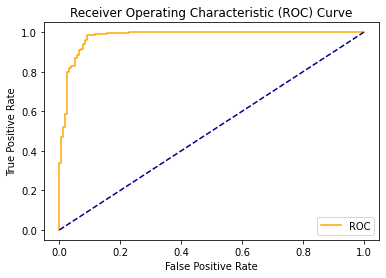

Test ROC
0.7735798597182209
Threshold value is: 0.8587677667266914


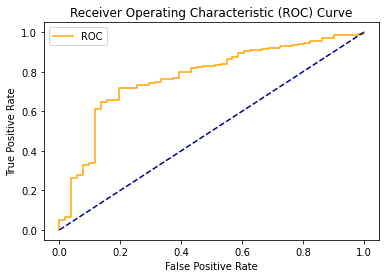


 
 =====================   Train Dataset    ======================
98.15668202764977
              precision    recall  f1-score   support

         0.0       0.64      0.91      0.75       154
         1.0       1.00      0.98      0.99      4837

    accuracy                           0.98      4991
   macro avg       0.82      0.95      0.87      4991
weighted avg       0.99      0.98      0.98      4991



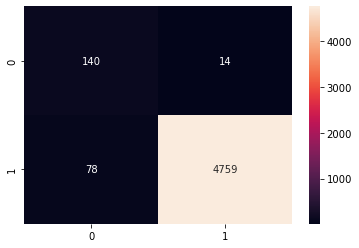

Accuracy of on training set: 0.99


 =====================   Test Dataset    =======================
71.875
              precision    recall  f1-score   support

         0.0       0.08      0.80      0.15        51
         1.0       0.99      0.72      0.83      1613

    accuracy                           0.72      1664
   macro avg       0.54      0.76      0.49      1664
weighted avg       0.96      0.72      0.81      1664



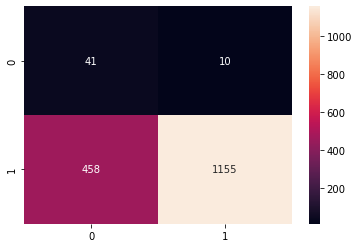

Accuracy of classifier on test set: 0.96


 =======================   Test-ROC    =========================
roc_auc = 0.7736


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.80392157 0.71605704]
average accuracy:  0.7599893026026281
f1 0.8315334773218144


In [51]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=10,
#                              n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.001,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf,10)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(rf, X_test, Y_test)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

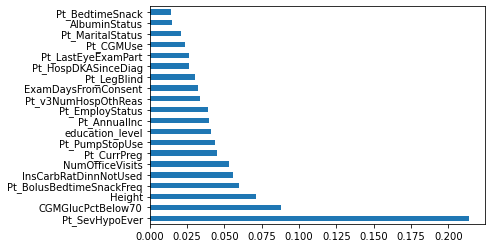

In [52]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

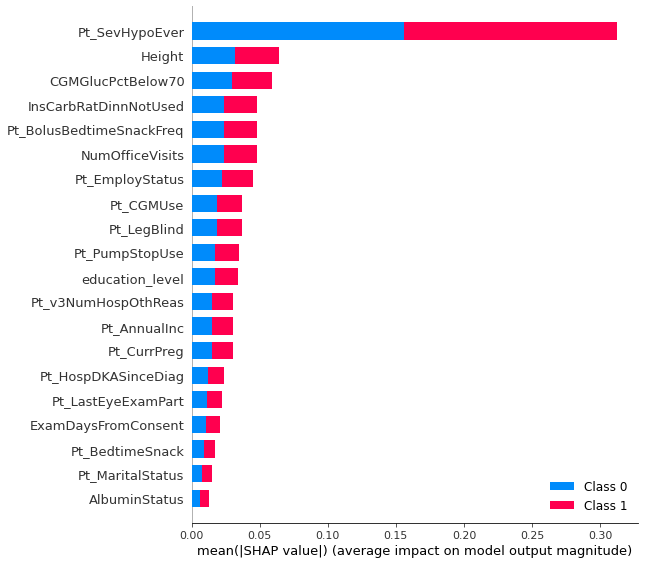

In [53]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.718, doublecheck: 0.718
Accuracy for the fold no. 2 on the test set: 0.717434869739479, doublecheck: 0.717434869739479


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 3 on the test set: 0.6693386773547094, doublecheck: 0.6693386773547094
Accuracy for the fold no. 4 on the test set: 0.7214428857715431, doublecheck: 0.7214428857715431


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 5 on the test set: 0.7575150300601202, doublecheck: 0.7575150300601202
Accuracy for the fold no. 6 on the test set: 0.6893787575150301, doublecheck: 0.6893787575150301


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 7 on the test set: 0.7154308617234469, doublecheck: 0.7154308617234469
Accuracy for the fold no. 8 on the test set: 0.6893787575150301, doublecheck: 0.6893787575150301
Accuracy for the fold no. 9 on the test set: 0.7234468937875751, doublecheck: 0.7234468937875751

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)



Accuracy for the fold no. 10 on the test set: 0.7134268537074149, doublecheck: 0.7134268537074149
Train ROC
0.8108573254324754
Threshold value is: 0.5645393576739618


The max_iter was reached which means the coef_ did not converge


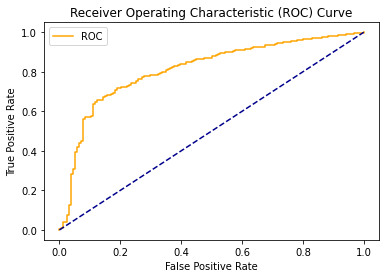

Test ROC
0.7649490050204831
Threshold value is: 0.6627817837514922


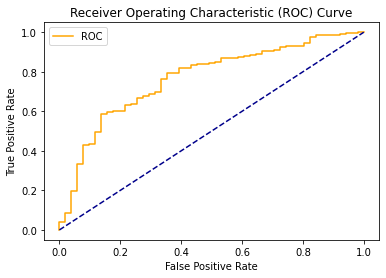


 
 =====================   Train Dataset    ======================
66.15908635543978
              precision    recall  f1-score   support

         0.0       0.07      0.88      0.14       154
         1.0       0.99      0.65      0.79      4837

    accuracy                           0.66      4991
   macro avg       0.53      0.77      0.46      4991
weighted avg       0.97      0.66      0.77      4991



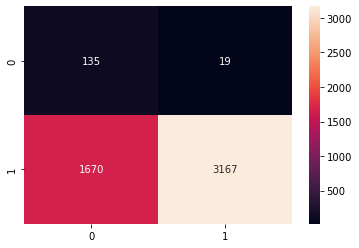

Accuracy of on training set: 0.72


 =====================   Test Dataset    =======================
59.254807692307686
              precision    recall  f1-score   support

         0.0       0.06      0.86      0.11        51
         1.0       0.99      0.58      0.74      1613

    accuracy                           0.59      1664
   macro avg       0.53      0.72      0.43      1664
weighted avg       0.96      0.59      0.72      1664



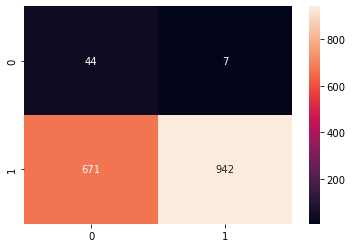

Accuracy of classifier on test set: 0.71


 =======================   Test-ROC    =========================
roc_auc = 0.7649


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.8627451  0.58400496]
average accuracy:  0.7233750288708167
f1 0.7353629976580796


In [54]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg,10)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

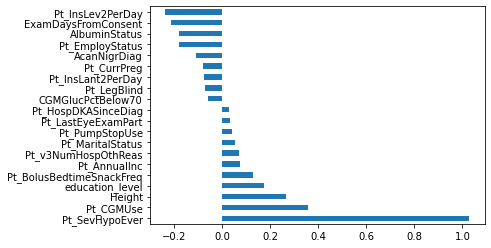

In [55]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 4 - Decision tree

Accuracy for the fold no. 1 on the test set: 0.9329329329329329, doublecheck: 0.9329329329329329
Accuracy for the fold no. 2 on the test set: 0.938877755511022, doublecheck: 0.938877755511022
Accuracy for the fold no. 3 on the test set: 0.9318637274549099, doublecheck: 0.9318637274549099
Accuracy for the fold no. 4 on the test set: 0.9378757515030061, doublecheck: 0.9378757515030061
Accuracy for the fold no. 5 on the test set: 0.9328657314629258, doublecheck: 0.9328657314629258
Train ROC
0.9050594846542748
Threshold value is: 1.0


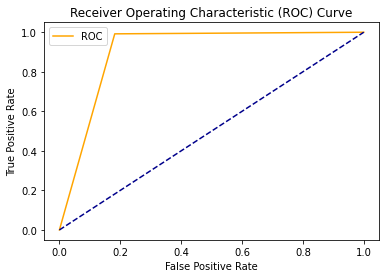

Test ROC
0.5047287358836902
Threshold value is: 1.0


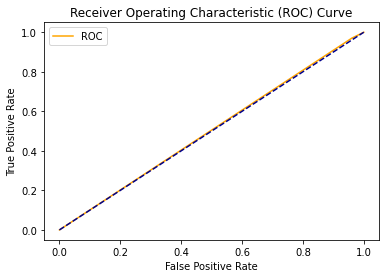


 
 =====================   Train Dataset    ======================
98.65758365057103
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79       154
         1.0       0.99      0.99      0.99      4837

    accuracy                           0.99      4991
   macro avg       0.88      0.91      0.89      4991
weighted avg       0.99      0.99      0.99      4991



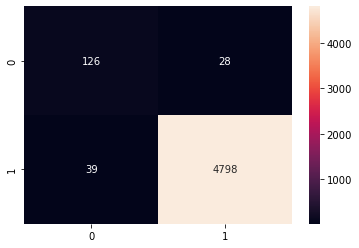

Accuracy of on training set: 0.99


 =====================   Test Dataset    =======================
94.17067307692307
              precision    recall  f1-score   support

         0.0       0.04      0.04      0.04        51
         1.0       0.97      0.97      0.97      1613

    accuracy                           0.94      1664
   macro avg       0.50      0.50      0.50      1664
weighted avg       0.94      0.94      0.94      1664



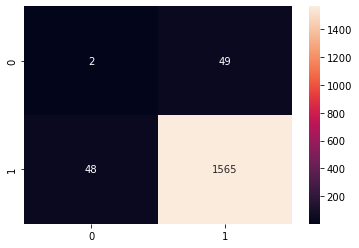

Accuracy of classifier on test set: 0.94


 =======================   Test-ROC    =========================
roc_auc = 0.5047


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.03921569 0.97024179]
average accuracy:  0.5047287358836902
f1 0.9699411217849395


In [56]:
clf = DecisionTreeClassifier(
                        random_state=0,
                        criterion='gini',
                        splitter = 'best',
                        max_depth = 100,
                        max_features = 20)
# clf.fit(X_train, Y_train)
clf = cross_val(clf)

# pred=clf.predict(X_test)
# pred_train=clf.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(clf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(clf, X_test, Y_test)

pred = (clf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (clf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(clf, X_train, Y_train, pred_train)
test_results(clf, X_test, Y_test, pred)

# ROC
ROC_results(clf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(clf, Y_test, pred)

<AxesSubplot:>

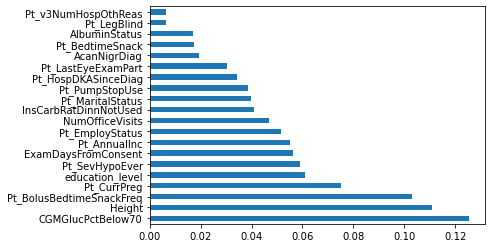

In [57]:

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 5 - K-Nearest Neighbors

Accuracy for the fold no. 1 on the test set: 0.9469469469469469, doublecheck: 0.9469469469469469
Accuracy for the fold no. 2 on the test set: 0.9428857715430862, doublecheck: 0.9428857715430862
Accuracy for the fold no. 3 on the test set: 0.9458917835671342, doublecheck: 0.9458917835671342
Accuracy for the fold no. 4 on the test set: 0.9529058116232465, doublecheck: 0.9529058116232465
Accuracy for the fold no. 5 on the test set: 0.9458917835671342, doublecheck: 0.9458917835671342
Train ROC
0.9126900595786269
Threshold value is: 1.0


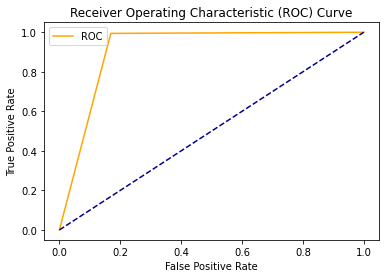

Test ROC
0.4977146469251061
Threshold value is: 2.0


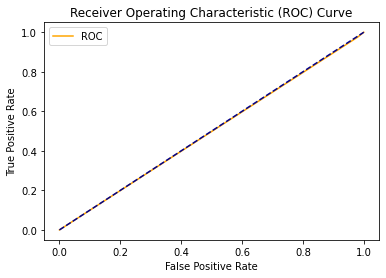


 
 =====================   Train Dataset    ======================
98.91805249449008
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83       154
         1.0       0.99      0.99      0.99      4837

    accuracy                           0.99      4991
   macro avg       0.91      0.91      0.91      4991
weighted avg       0.99      0.99      0.99      4991



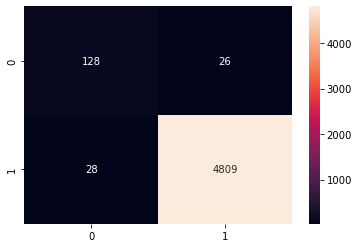

Accuracy of on training set: 0.99


 =====================   Test Dataset    =======================
3.064903846153846
              precision    recall  f1-score   support

         0.0       0.03      1.00      0.06        51
         1.0       0.00      0.00      0.00      1613

    accuracy                           0.03      1664
   macro avg       0.02      0.50      0.03      1664
weighted avg       0.00      0.03      0.00      1664



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


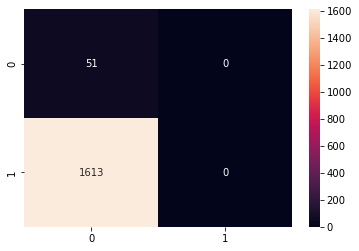

Accuracy of classifier on test set: 0.95


 =======================   Test-ROC    =========================
roc_auc = 0.4977


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [1. 0.]
average accuracy:  0.5
f1 0.0


In [58]:
knn = KNeighborsClassifier(
    n_neighbors =1,
    weights = "uniform", # uniform, distance
    algorithm =  'brute', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
)

# knn.fit(X_train, Y_train)
knn = cross_val(knn)

# pred=knn.predict(X_test)
# pred_train=knn.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(knn, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(knn, X_test, Y_test)

pred = (knn.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (knn.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(knn, X_train, Y_train, pred_train)
test_results(knn, X_test, Y_test, pred)

# ROC
ROC_results(knn, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(knn, Y_test, pred)

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.968968968968969, doublecheck: 0.968968968968969
Accuracy for the fold no. 2 on the test set: 0.968937875751503, doublecheck: 0.968937875751503
Accuracy for the fold no. 3 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 4 on the test set: 0.966933867735471, doublecheck: 0.966933867735471
Accuracy for the fold no. 5 on the test set: 0.966933867735471, doublecheck: 0.966933867735471
Train ROC
0.7989389151266348
Threshold value is: 0.9612549610414043


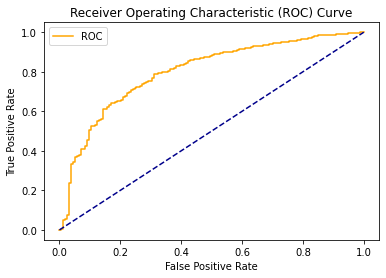

Test ROC
0.7652164399547792
Threshold value is: 0.9601326167439462


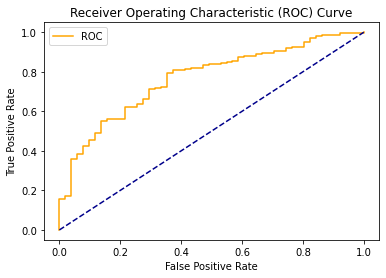


 
 =====================   Train Dataset    ======================
78.62151873372069
              precision    recall  f1-score   support

         0.0       0.09      0.69      0.17       154
         1.0       0.99      0.79      0.88      4837

    accuracy                           0.79      4991
   macro avg       0.54      0.74      0.52      4991
weighted avg       0.96      0.79      0.86      4991



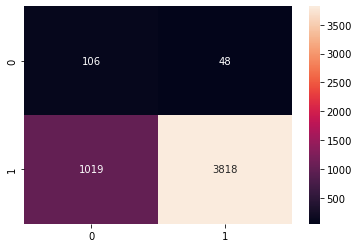

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
78.72596153846155
              precision    recall  f1-score   support

         0.0       0.09      0.65      0.16        51
         1.0       0.99      0.79      0.88      1613

    accuracy                           0.79      1664
   macro avg       0.54      0.72      0.52      1664
weighted avg       0.96      0.79      0.86      1664



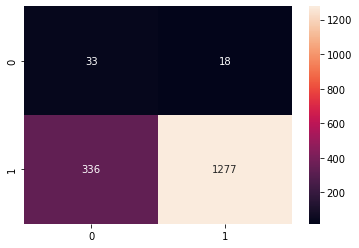

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.7652


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.64705882 0.7916925 ]
average accuracy:  0.7193756609897524
f1 0.8782668500687758


In [59]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(lda, X_test, Y_test)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


## Model 7- Gaussian Naive Bayes

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 1 on the test set: 0.955955955955956, doublecheck: 0.955955955955956
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 2 on the test set: 0.9639278557114228, doublecheck: 0.9639278557114228
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 3 on the test set: 0.93687374749499, doublecheck: 0.93687374749499
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 4 on the test set: 0.9559118236472945, doublecheck: 0.9559118236472945
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Accuracy for the fold no. 5 on the test set: 0.9559118236472945, doublecheck: 0.9559118236472945
GaussianNB(var_smoothing=1.0)
Train ROC
0.7656323416091868
Threshold value is: 0.9885874404579174


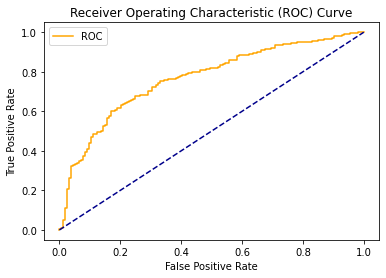

Test ROC
0.7260980027472861
Threshold value is: 0.9893302353313539


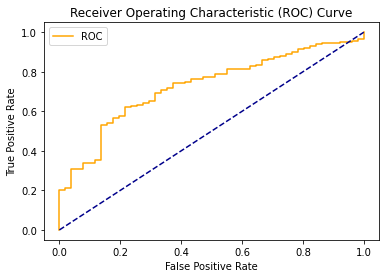


 
 =====================   Train Dataset    ======================
63.79483069525145
              precision    recall  f1-score   support

         0.0       0.06      0.80      0.12       154
         1.0       0.99      0.63      0.77      4837

    accuracy                           0.64      4991
   macro avg       0.53      0.72      0.45      4991
weighted avg       0.96      0.64      0.75      4991



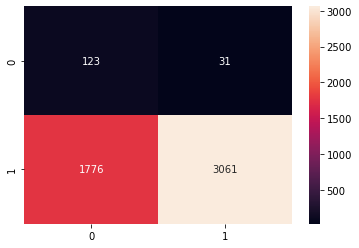

Accuracy of on training set: 0.95


 =====================   Test Dataset    =======================
62.56009615384615
              precision    recall  f1-score   support

         0.0       0.06      0.78      0.11        51
         1.0       0.99      0.62      0.76      1613

    accuracy                           0.63      1664
   macro avg       0.53      0.70      0.44      1664
weighted avg       0.96      0.63      0.74      1664



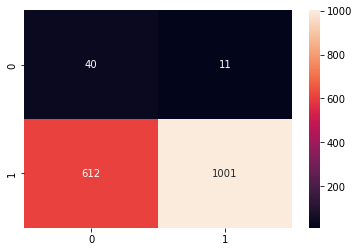

Accuracy of classifier on test set: 0.95


 =======================   Test-ROC    =========================
roc_auc = 0.7261


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.78431373 0.62058277]
average accuracy:  0.702448245262147
f1 0.7626666666666667


In [60]:
gnb = GaussianNB()

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
# nbModel_grid.fit(X_train, Y_train)
nbModel_grid = cross_val(nbModel_grid)

# best parameters
print(nbModel_grid.best_estimator_)

gnb = GaussianNB(priors=None, var_smoothing=1.0)
gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)
